In [1]:
from simulation_functions import index, simulation_, plot
from interpolation_functions import T_K
from make_noise_updated import simulate_noise
import numpy as np
import matplotlib.pyplot as plt
from microlensing import make_microlensing
from wavelet import wavelet, iuwt, MAD
import scipy
from scipy import signal
import sys

np.set_printoptions(threshold=sys.maxsize)

%matplotlib inline

In [2]:

# calling the microlensing function to get magnitudes of different microlensing curves, visualized below
mic0, mic1, mic2, mic3 = make_microlensing(u0=1.5), make_microlensing(u0=1.4, d= -1500, te= 50),make_microlensing(u0=1.9, d = 500, te = 700),make_microlensing(u0=1.1, d = 1000)
mag0, mag1,mag2,mag3 = mic0[1], mic1[1],mic2[1],mic3[1]
# microlensing magnitude array
mic_mag = np.concatenate([mag0[np.newaxis,:], mag1[np.newaxis,:],mag2[np.newaxis,:],mag3[np.newaxis,:]])


sim = simulate_noise(15) # first argument dt_max: time delay is chosen randomly between 0 and dtmax, with noise
time_delays = sim[2]
ts = sim[0]+np.max(time_delays) # observation time sample (same for all curves= non_shifted)+max (time delay)

fs = sim[1] # f(ts)
# f(ts) + microlensing:
fsm = np.concatenate([(fs[0]+mag0)[np.newaxis,:],(fs[1]+mag1)[np.newaxis,:],(fs[2]+mag2)[np.newaxis,:],(fs[3]+mag3)[np.newaxis,:]])

# original curve : concatenated and shifted
f = sim[6]
t = sim[7]

sampling = 3
h=sampling
# desired sampling for each curve


tk = np.linspace(np.min(ts),np.max(ts),np.int(np.abs((np.min(ts)-np.max(ts))/h)),dtype=float,retstep=True)[0]  # [1] gives approx : h


# dt is part of the argument ts+dt -tk of the sinc matrix
dt = np.array([1.,1.,1.,1.])
arg = np.argsort(time_delays)[::-1] # in index terms: from highest time delay to lowest
dt[arg[0]] = 0 #curve with highest time delay has dt = 0
#in what comes: curve with ith highest time delay has :dt = max time delay- ith highest time delay
dt[arg[1]] = np.max(time_delays)-time_delays[arg[1]]
dt[arg[2]] = np.max(time_delays)-time_delays[arg[2]]
dt[arg[3]] = np.max(time_delays)-time_delays[arg[3]]

matrix = []
for i in range(4):
    matrix.append(np.array([(ts[:,np.newaxis])-dt[i]-tk[np.newaxis,:]])) 
matrix = np.array(matrix)

A = np.sinc(np.concatenate([matrix[0],matrix[1],matrix[2],matrix[3]],axis =0)/h) # 4 x s x K  , without h* 

Y= np.concatenate([fsm[0][np.newaxis,:],fsm[1][np.newaxis,:],fsm[2][np.newaxis,:],fsm[3][np.newaxis,:]]) # 4 x s


In [3]:
# multiplication functions:
noise_std = sim[3]#np.array([MAD(Y[i]) for i in range(4)])

print(noise_std,sim[3])
def AT(X,A,Y, M): 
    '''
    calculateS the weighted mean of A.T(Y-AX)
    input:
    X : array with shape k, solution of interpolation
    A : tensor of shape 4xsxk, sinc matrix
    Y : matrix of shape 4xs, magnitudes of original time sampling
    '''
    
    #M = np.zeros((4, len(tk)))
    #M[0],M[1],M[2],M[3] = M0,M1,M2,M3
    sum_ = 0
    for i in range(4):
        sum_ += np.dot(A[i].T, Y[i] - A[i] @ X - A[i] @ M[i])#*((1/noise_std[i])**2)
    
    return sum_#/np.sum(1/(noise_std**2))

def multiplication(X,S): # X.S
    '''
    multiplies X by S[i] and takes the arithmetic mean
    '''
    this =[]
    for i in range(4):
        this.append(np.dot(X,S[i]))
    this = np.array(this)
    return np.mean(this,axis=0)

def multiplication_T(X,S): # X.S.T

    '''
    multiplies X by S[i].T and take the arithmetic mean
    '''
    this =[]
    for i in range(4):
        this.append(np.dot(X,S[i].T))
    this = np.array(this)
    return np.mean(this,axis=0)

def residuals(Y,A,X,M):
    '''
    calculates the residual or each while loop iteration
    '''
    sum = 0
    for i in range(4):
        sum += ((Y-A@X-A@M[i])**2)
    return np.sum(sum)

[0.00410578 0.00630178 0.01092155 0.02498405] [0.00410578 0.00630178 0.01092155 0.02498405]


In [4]:
def linorm(S, nit):
    '''
    calculates the lipschitz constant given a matrix
    '''
    x0 = np.random.rand(S.shape[1])  # chose [1] per the implementation of the power iteration method in wiki
    x0 = x0 /np.linalg.norm(x0)
    for i in range(nit):
        x = multiplication(x0,S)#np.dot(x0,S)
        xn = np.linalg.norm(x)
        xp = x / xn#     
        y = multiplication_T(xp,S) # the S.T is done within the functionas S[i].T not S.T[i]
        yn = np.linalg.norm(y)  
        x0 = y / yn
    return 1./xn
mu = linorm(A,20)/170 # = 0.0038

#initializing X, Ms, Count, S_var_M
X = np.zeros(len(tk))
M = np.zeros((4,len(tk)))
M_new = np.zeros((4,len(tk)))


count = 0
R = [np.sum(Y ** 2)]
epsilon = 0.3

S_var_M = np.zeros((4,len(tk)-1)) # to store the variance in M for each M curve



In [5]:
original = []
for i in range(4):
    original.append(np.mean(fsm[i]))

In [6]:
lvl = 8

th_s = np.zeros(lvl) # threshold scale
th = np.zeros(lvl)  # actual threshold for each level
dirac = scipy.signal.unit_impulse(len(tk), idx=np.int(len(tk)/2)) 

for i in range(lvl):
    th_s[i] = np.sqrt(np.sum((wavelet(dirac, lvl)[i])**2)) # threshold scale calculation

thresholds = []
for i in range(4):
    for j in range(lvl):
        th[j] = noise_std[i]*th_s[j] # threshold calculation
    thresholds.append(th/100.)

thresholds = np.array(thresholds) # shape is 4 x lvl , thresholds[i][j] is the threshold for curve i, level j

def _bayes_thresh(details,var):
    '''
    alternate method to calculate the threshold, called the Bayes Shrink method
    
    input:
    details: output of the wavelet for a specific level, ie  : w[j] for level j
    var: std**2
    
    output:
    a threshold for each level.
    '''
    dvar = np.mean(details*details)
    eps = np.finfo(details.dtype).eps
    thresh = var / np.sqrt(max(dvar - var, eps))
    return thresh

iteration  0
iteration  100
iteration  200
iteration  300
iteration  400
iteration  500
iteration  600
iteration  700
iteration  800
iteration  900


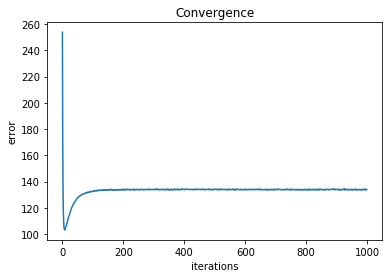

In [7]:
max_var = np.abs(np.max((f[1:]-f[:-1])))#/(t[1:]-t[:-1]))) # exact if without noise (f doesnt have noise)


count = 0
while (R[-1] > epsilon) and (
        count < 1000):  # 5000 is a good amount of counts
    if count%100 == 0:
        print('iteration ', count)
    for j in range(20):
        X_new = X + mu * AT(X,A,Y,M)
        X = X_new.copy()  
    
        X = X + (np.mean(original)-np.mean(X))
    
        S_var = (X[:-1]-X[1:])#/((tk[:-1]-tk[1:]))
        sign = np.sign(S_var[np.abs(S_var) >2*max_var])
        loc = np.where(np.abs(S_var) >2*max_var)
        X[loc] = X[loc] - 1.*max_var*sign
        
        
    for i in range(20):
        for i in range(4):
            M_new[i] = M[i] + mu*np.dot(A[i].T, Y[i] - A[i] @ X- A[i] @ M[i])
            M[i] = M_new[i].copy()  
        
            #S_var_M[i] = ((M[i])[:-1]-(M[i])[1:])#/((tk[:-1]-tk[1:]))
            #sign = np.sign(S_var_M[i][np.abs(S_var_M[i]) >2*max_var])
            #loc = np.where(np.abs(S_var_M[i]) >2*max_var)
            #M[i][loc] = M[i][loc] - 2*max_var*sign
            
            
            w = wavelet(M[i], lvl)
            
            for j in range(lvl-1): # lvl-1 to not include the last level
#             threshold = _bayes_thresh(w[j],noise_std[i]**2)     # to use the bayes Shrink, uncomment
#             (w[j])[w[j] <= threshold] = 0 
                #plt.plot(w[j])
                #plt.plot([0,w[j].size],[thresholds[i][j],thresholds[i][j]])
                #plt.show()
                (w[j])[np.abs(w[j]) <= (thresholds[i][j])] = 0 
    
            w[0] = 0
            #w[-1] = 0 # set last level coeff to 0
            M[i] = iuwt(w)  # inverse wavelet
        
            M[M<0] = 0 # positivity
 
    R.append(residuals(Y,A,X,M)) 
    count += 1


plt.title('Convergence')
plt.plot(np.array(R[1:]))
plt.xlabel('iterations')
plt.ylabel('error')
plt.show()

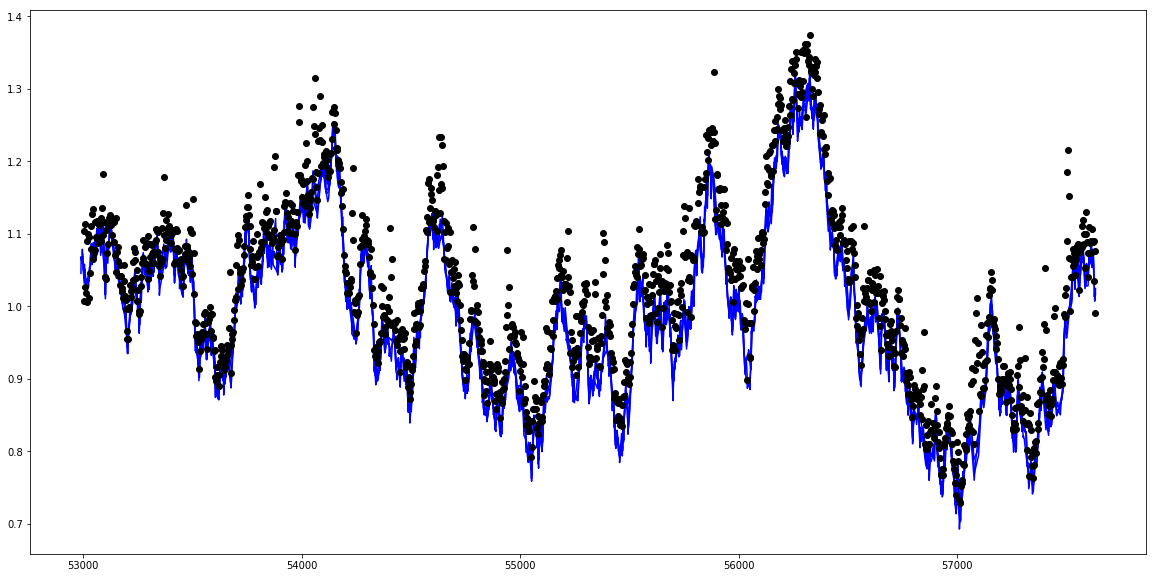

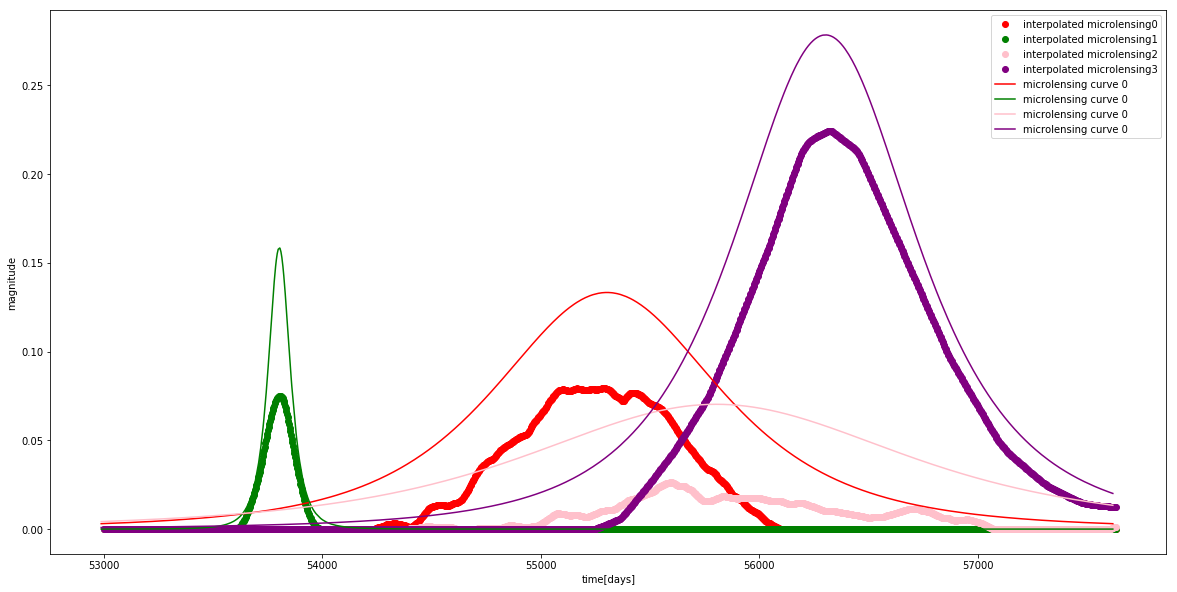

In [9]:
%matplotlib inline
cut = np.logical_and(X < np.max(Y), X > np.min(Y))
plt.figure(figsize=(20,10))

## with microlensing:
# for i in range(4):
#     plt.plot(ts-dt[i], Y[i], 'o', label='microlensed light curve '+str(i))    


# without microlensing:
for i in range(4):
    plt.plot(ts-dt[i], fs[i], '-', label='intrinsic light curve '+str(i), color = 'blue')

# resulting interpoation, apply [cut] to X if desired
plt.plot(tk, X,'o', label='interpolated intrinsic light curve', color='black')   
plt.show()

plt.figure(figsize=(20,10))
plt.plot(tk, M[0],'o', label='interpolated microlensing0',color = 'r')
plt.plot(tk, M[1],'o', label='interpolated microlensing1', color = 'g')
plt.plot(tk, M[2],'o', label='interpolated microlensing2', color = 'pink')
plt.plot(tk, M[3],'o', label='interpolated microlensing3', color = 'purple')

# microlensing original curves
plt.plot(mic0[0],mic_mag[0],'-', label = "microlensing curve 0", color = 'r',markersize=12)
plt.plot(mic0[0],mic_mag[1],'-', label = "microlensing curve 0", color = 'g',markersize=12)
plt.plot(mic0[0],mic_mag[2],'-', label = "microlensing curve 0", color = 'pink',markersize=12)
plt.plot(mic0[0],mic_mag[3],'-', label = "microlensing curve 0", color = 'purple',markersize=12)


#plt.plot(tk, X,'o', label='interpolated', color='black')
#plt.plot(t,f,'o', label = 'true')
plt.xlabel('time[days]')
plt.ylabel('magnitude')
#plt.title('demixing signals: level 4, bolded are original microlensing curves, all except purple are zero')
plt.legend()
#plt.savefig("wavelet level 4 using \"BayesShrink\" threshold method .png")
plt.show() 